<a href="https://colab.research.google.com/github/RonaldBH/Ruben-Ronald-Bautista-Huillca/blob/main/Bautista_Huillca_Ruben_Tendencias_Politicas_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Clasificación de tendencias politicas en tweets (Perceptrón Multicapa)

* En este notebook vamos a clasificar una serie de tweets etiquetados por un partido político (psoe, pp, vox, podemos y ciudadanos) que corresponden a la tendencia politica de la cuenta que publicó ese tweet,


* El ejercicio que vamos a realizar a continuación se pueden comparar los resultados que vamos a obtener con la Red Neuronal respecto a los obtenidos con los modelos generados por los algoritmos de clasificación vistos.


* Los pasos que vamos a dar son los siguientes:

    1. Cargar los datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Particionado de datos (Train y Test)
    4. Bolsa de palabras y codificación del target
    5. Definición de la Red Neuronal
    6. Entrenamiento de la Red Neuronal
    7. Evaluación del modelo

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [21]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

TWEETS_FILE = 'tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python', error_bad_lines=False)

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Los ordenamos por fecha
df = df.sort_values(by='timestamp')

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

<ipython-input-21-f8a7195ac7ed>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python', error_bad_lines=False)


Número de Tweets Cargados: 101017
Número de Tweets a procesar: 101017


,cuenta,partido,timestamp,tweet
30832,sanchezcastejon,psoe,"1,572,964,487.00","¡Siguiente parada, #Badajoz! Os espero a parti..."
80178,ivanedlm,vox,"1,612,631,641.00","Hoy, desde Lloret de Mar, localidad turística ..."
54870,lugaricano,ciudadanos,"1,582,531,226.00","@FinancialTimes ""Cursus honorum"""
32482,GirautaOficial,ciudadanos,"1,573,163,522.00","Si no somos decisivos, España tiene un problem..."
32891,PSOE,psoe,"1,573,471,143.00",🗣️ @abalosmeco: Lo importante es el compromiso...
7894,Alber_Canarias,podemos,"1,561,282,853.00",A partir de ahí continua una vereda llena de r...
96306,Santi_ABASCAL,vox,"1,618,578,084.00",Esta mañana en #Alcorcón donde una vez más la ...
81876,ivanedlm,vox,"1,612,974,034.00",Hoy han venido algunos separatas y progres a a...
67692,Yolanda_Diaz_,podemos,"1,585,658,224.00","Además, @empleogob ha trabajado con @Universid..."
92931,Ortega_Smith,vox,"1,617,299,802.00",Acompañando a los madrileños en la misa de Mié...


* Filtramos los tweets por fecha. Nos quedamos con los tweets a partir de una fecha dada.

In [22]:
import datetime
import time

# Filtramos los tweets a partir de una fecha
DATE = "01/04/2019"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Mostramos un sample y el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets a procesar: 100786


,cuenta,partido,timestamp,tweet
64908,garciaretegui,psoe,"1,585,145,159.00",@Murciasalud @LopezMirasF Que repasen las Pres...
50626,PSOE,psoe,"1,581,148,386.00","“Por primera vez en mucho tiempo, un president..."
89879,Tonicanto1,ciudadanos,"1,616,080,752.00","Presupuesto destinado a la Salud Mental: 2,5 m..."
47557,monasterioR,vox,"1,579,767,735.00",@vox_es presenta la moción para investigar...l...
21556,odonelorza2011,psoe,"1,570,005,314.00",@rafacamu @COTransparencia @PSOE @gpscongreso ...
96497,PODEMOS,podemos,"1,618,681,311.00","📽 @PabloIglesias: “Los que peináis canas, la g..."
77324,PabloIglesias,podemos,"1,611,822,517.00",https://t.co/KDXzwCW9mM
29045,InesArrimadas,ciudadanos,"1,572,436,163.00",@Adrilastra ¡Muchas gracias por la felicitació...
82634,populares,pp,"1,613,472,313.00",📡 @pablocasado_ preside la reunión del Comité ...
23665,ahorapodemos,podemos,"1,570,811,400.00",Pedro Sánchez nunca quiso pactar con Unidas Po...


* Tweets publicados por partido político

In [23]:
df_count = df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)
df_count['PCT'] = (df_count['tweet'] / df_count['tweet'].sum())*100
df_count

,partido,tweet,PCT
3,psoe,23152,22.97
1,podemos,19807,19.65
2,pp,19496,19.34
0,ciudadanos,19429,19.28
4,vox,18902,18.75


* Nos quedamos solo con el nombre del partido y el tweet

In [24]:
tweets = [list(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 100786


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema



In [29]:
!pip install spacy
!python -m spacy download es_core_news_sm

2023-09-06 00:30:49.077373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 45.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [30]:
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

def normalize(tweets, min_words=3):
    """
    Función que dada una lista de tweets ([tweet, clase]), normaliza los tweets y devuelve una lista
    con los tweets normalizados, descartando aquellos tweets que tras la normalización tengan menos de
    "min_words" palabras en el tweet.

    :param tweets:       Lista de Tweets ([tweet, clase]) con el tweet y la clase a la que pertenece
    :param min_words:    Número minimo de palabras que tiene que tener un tweet tras la normalización
    :return:             Lista de Tweets ([tweet, clase]) normalizados
    """
    tweets_list = []
    for tweet in tqdm(tweets):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())

        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               and (not word.text.startswith('@'))
               and (not word.text.startswith('http'))
               and (not ':' in word.text)])

        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append([tw, tweet[1]])
    return tweets_list

# Normalizamos las frases
X_norm = normalize(tweets)

100%|██████████| 100786/100786 [21:09<00:00, 79.38it/s]


#### <a name="Escritura">Guardado de los tweets normalizados en un fichero binario</a>

* Se guarda una lista de listas, donde en cada una de las listas se tiene:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [32]:
import pickle

filename = './models/normalized_tweets_tokens.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm, save_list)
save_list.close()


#### <a name="Lectura">Lectura de los tweets normalizados de un fichero binario</a>

* Lectura de una lista con la siguiente estructura:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [33]:
import pickle

filename = './models/normalized_tweets_tokens.pickle'
X_norm = pickle.load(open(filename, 'rb'))


<hr>


## Particionado de Datos (Train y Test)

* Dado que las temáticas de los tweets varian en función del tiempo (tienen caracter temporal), vamos a particionar los datos temporalmente.


* Seleccionaremos como tweets de entrenamiento aquellos que se han escrito hasta una determinada fecha y como tweets de test los últimos tweets escritos.


* Seleccionaremos un 2% de tweets de test, siendo estos los últimos tweets registrados en el dataset (los tweets están escritos de manera cronológica).


* Por tanto nos vamos a quedar con:
    - 98% de datos de entrenamiento
    - 2% de datos de test

In [34]:
# Divido los datos en dos listas
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in X_norm]
y = np.array([doc[1] for doc in X_norm])

# Particionamos los datos en Entrenamiento y Test

PCT_TEST = 0.02
n_tail = len(X) - int(len(X) * PCT_TEST)
print('Corte en el tweet número {} de los {} tweets del Dataset.'.format(n_tail, len(X)))

X_train = X[:n_tail]
y_train = y[:n_tail]
X_test = X[n_tail:]
y_test = y[n_tail:]

print('Tweets de entrenamiento: {}'.format(len(X_train)))
print('Tweets de Test: {}'.format(len(X_test)))


Corte en el tweet número 91072 de los 92930 tweets del Dataset.
Tweets de entrenamiento: 91072
Tweets de Test: 1858


<hr>


# Bolsa de palabras y codificación del target


* Al igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* vamos a trabajar con las 1500 palabras de mayor frecuencia del corpus.


* Realizaremos una codificación del nombre del partido político utilizando la clase "LabelEncoder()" de scikit.

In [35]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer


# Bolsa de Palabras
max_words = 1500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_matrix = tokenizer.texts_to_matrix(X_train, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test, mode='count')

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

<hr>


# Definición de la Red Neuronal



* Para clasificar los tweets en alguna de las 4 tendencias políticas definidas, vamos a crear una red con la siguiente arquitectura:
<span></span><br><br>
    - ***Capa 1***: Capa de entrada con 1000 Neuronas (una por palabra del corpus)
<span></span><br><br>
    - ***Capa 2***: 20 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 3***: 10 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 4***: Capa de salida con 5 neurona (una por tendencia política) y una función de activación 'softmax' para que nos "normalice la salida"
    
    
* Para las capas 2 y 3 vamos a poner un dropout del 20% para que nuestra red no se sobreajuste y generalize mejor


* Por último vamos a compilar la red:
<span></span><br><br>
    - ***Función de perdida: 'categorical_crossentropy'*** (Funciones de Perdida: https://keras.io/losses/)
<span></span><br><br>
    - ***Optimizador: 'adam'*** (Optimizadores: https://keras.io/optimizers/)
<span></span><br><br>
    - Metricas: en cada epoch pediremos que nos muestre el accuracy.

In [36]:
# Se fuerza a usar la CPU y no la GPU en caso de tener GPU en el ordenador
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [37]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

np.random.seed(9)
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=max_words))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


* Una vez creada la red mostramos su arquitectura:
    - 1500 Neuronas de entrada
    - Capa 2: 20 Neuronas
    - Conexiones "capa de entrada -> Capa 2" = (1500*20) + 20 = 30020 Conexiones
    - Capa 3: 10 Neuronas
    - Conexiones "Capa 2 -> Capa 3" = (20*10) + 10 = 210 Conexiones
    - Capa de salida: 4 Neuronas
    - Conexiones "Capa 3 -> Capa de salida" = (10*5) + 5 = 55 Conexiones

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                30020     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 30,285
Trainable params: 30,285
Non-trainable params: 0
_________________________________________________________________


<hr>


# Entrenamiento de la Red Neuronal


* Como lo que estamos haciendo es un ejemplo didáctico vamos a poner los siguientes valores:
<span></span><br><br>
    - *batch_size = 64* : Cada 64 tweets se calculan los nuevos pesos de la red
<span></span><br><br>
    - *epochs = 30*
<span></span><br><br>
    - *validation_data = Datos de Test*. Por cada epoch vamos a indicarle que realice una predicción con los datos de test y que vea su acierto.


In [39]:

history = model.fit(X_matrix, y_train, batch_size=64, epochs=30, verbose=2, validation_data=(X_matrix_test, y_test))


Epoch 1/30
1423/1423 - 8s - loss: 1.2485 - accuracy: 0.4791 - val_loss: 1.1158 - val_accuracy: 0.5662 - 8s/epoch - 6ms/step
Epoch 2/30
1423/1423 - 4s - loss: 1.0684 - accuracy: 0.5710 - val_loss: 1.1035 - val_accuracy: 0.5592 - 4s/epoch - 3ms/step
Epoch 3/30
1423/1423 - 4s - loss: 1.0319 - accuracy: 0.5863 - val_loss: 1.1034 - val_accuracy: 0.5721 - 4s/epoch - 3ms/step
Epoch 4/30
1423/1423 - 4s - loss: 1.0071 - accuracy: 0.5946 - val_loss: 1.1097 - val_accuracy: 0.5673 - 4s/epoch - 3ms/step
Epoch 5/30
1423/1423 - 4s - loss: 0.9890 - accuracy: 0.6034 - val_loss: 1.1221 - val_accuracy: 0.5587 - 4s/epoch - 3ms/step
Epoch 6/30
1423/1423 - 4s - loss: 0.9717 - accuracy: 0.6122 - val_loss: 1.1229 - val_accuracy: 0.5565 - 4s/epoch - 3ms/step
Epoch 7/30
1423/1423 - 4s - loss: 0.9595 - accuracy: 0.6187 - val_loss: 1.1330 - val_accuracy: 0.5597 - 4s/epoch - 3ms/step
Epoch 8/30
1423/1423 - 4s - loss: 0.9469 - accuracy: 0.6230 - val_loss: 1.1401 - val_accuracy: 0.5506 - 4s/epoch - 3ms/step
Epoch 9/

* Pintamos como evoluciona la función de perdida y el Accuracy por epoch tanto en entrenamiento como en test.

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

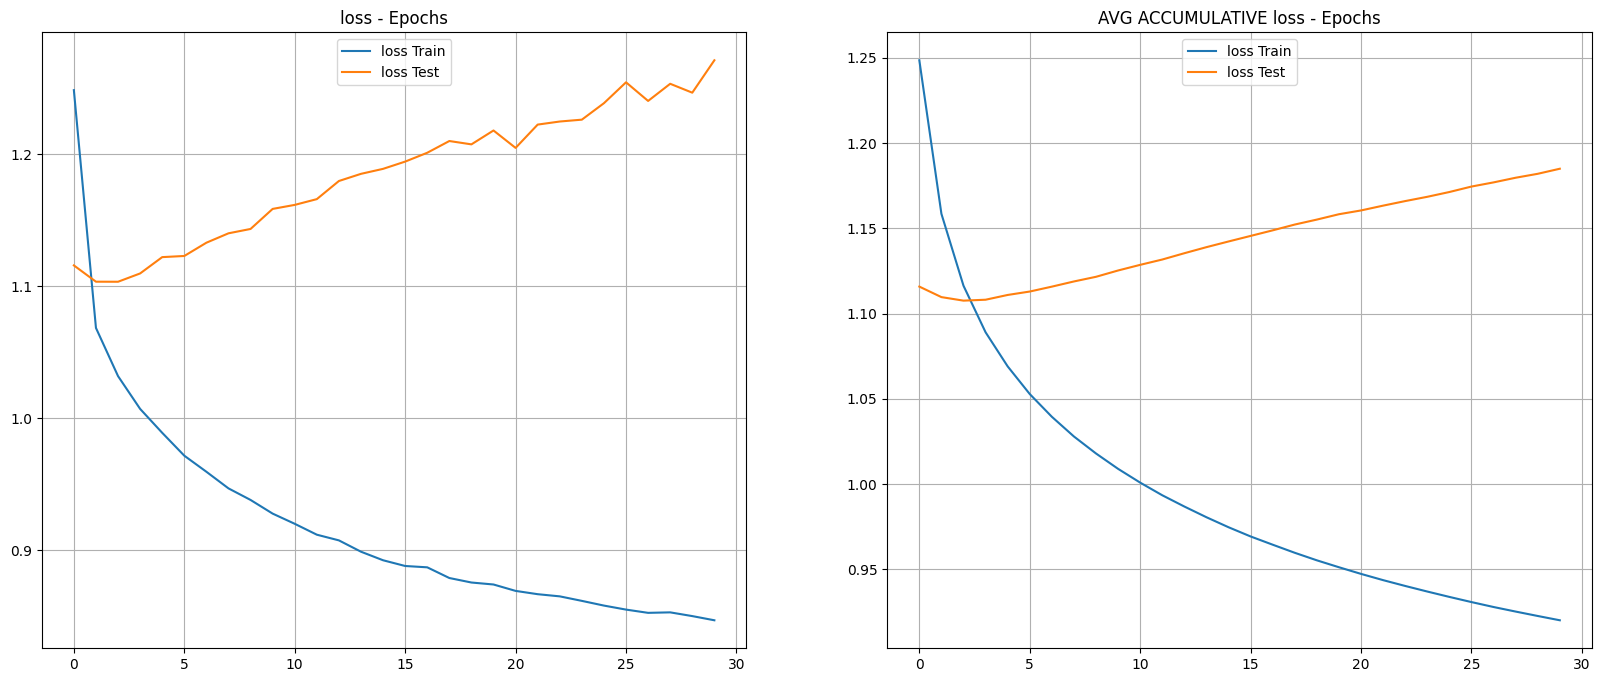

In [41]:
# Función de perdida
plot_metric(history=history, name='loss')

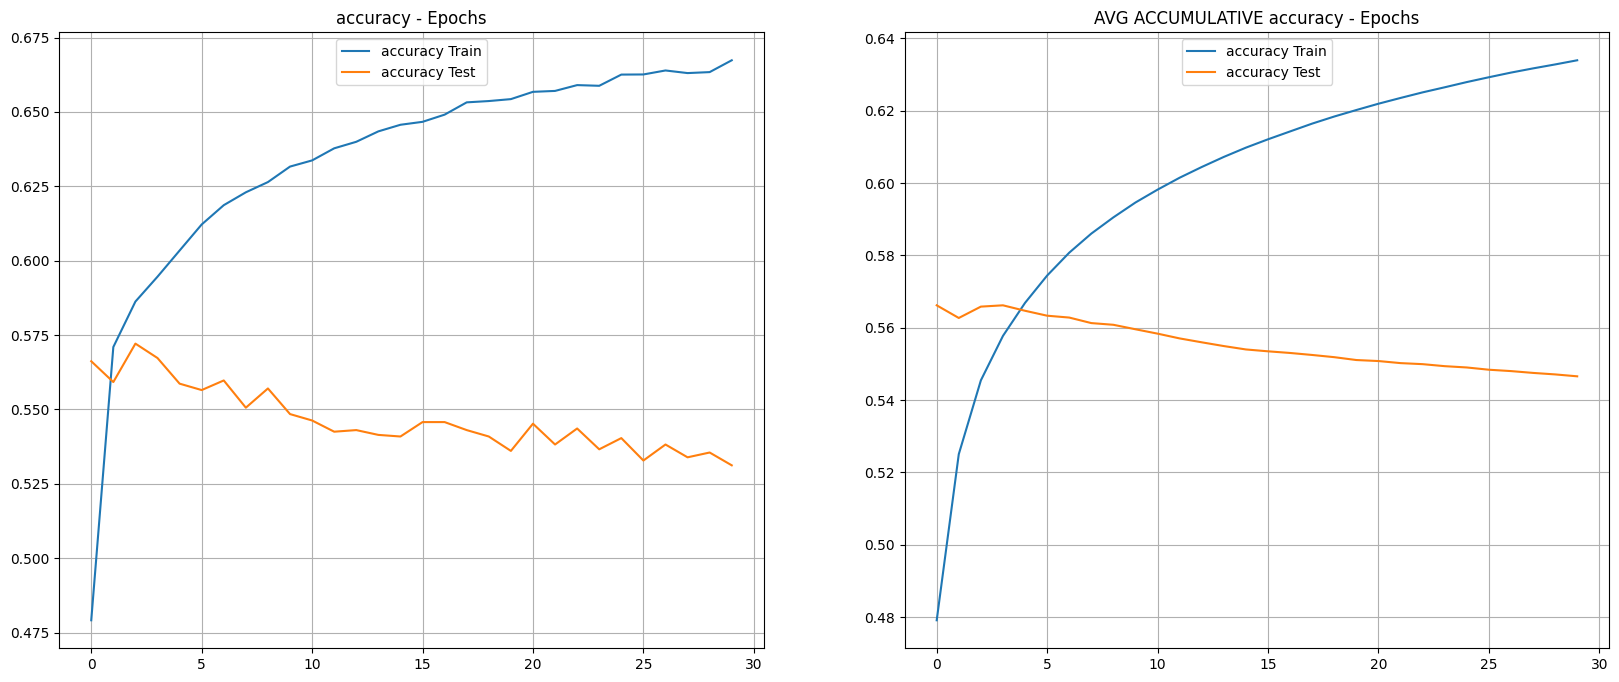

In [42]:
# Accuracy
plot_metric(history=history, name='accuracy')

<hr>


# Evaluamos el modelo

* Pasamos a evaluar el modelo, calculando las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred =np.argmax(model.predict(X_matrix_test),axis=1)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
confusion_matrix_test = confusion_matrix(y_true=y_true,
                                         y_pred=y_pred,
                                         labels=labels)
confusion_matrix_train = confusion_matrix(y_true=encoder.inverse_transform(y_train.reshape(-1)),
                                          y_pred=encoder.inverse_transform(np.argmax(model.predict(X_matrix),axis=1)),
                                          labels=labels)


59/59 [==============================] - 0s 4ms/step
Accuracy: 0.5312
F1: 0.5368
Precision: 0.5599
Recall: 0.5312
              precision    recall  f1-score   support

  ciudadanos       0.38      0.51      0.43       235
     podemos       0.52      0.62      0.57       312
          pp       0.63      0.50      0.56       517
        psoe       0.43      0.54      0.48       324
         vox       0.70      0.51      0.59       470

    accuracy                           0.53      1858
   macro avg       0.53      0.54      0.52      1858
weighted avg       0.56      0.53      0.54      1858

2846/2846 [==============================] - 8s 3ms/step


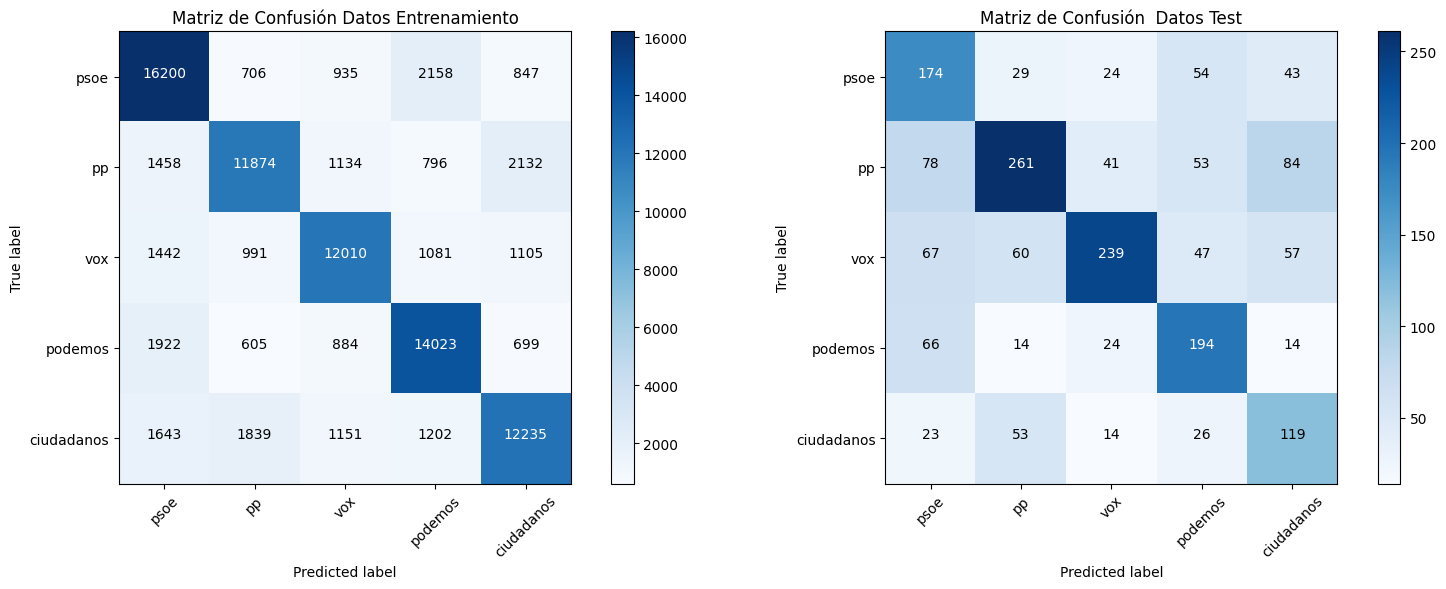

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Pintamos las matrices de confusión
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix_train, classes=labels, title='Matriz de Confusión Datos Entrenamiento')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix_test, classes=labels, title='Matriz de Confusión  Datos Test')
plt.show()